# Introduction: Transfer Learning in PyTorch

In this notebook, we'll see how to use PyTorch to train a classifier to identify 101 different objects in images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch, convolutional neural networks, and inference. 

## Dataset: CalTech 101

The dataset is the [CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) of images from 101 categories. There are about 40 to 800 images in each category. 

In [1]:
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import numpy as np
import pandas as pd

import os

from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#### Parameters

The parameters in this cell can be changed as needed.

In [2]:
trained_model = False
batch_size = 16

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [3]:
datadir = '/home/ubuntu/data/101_ObjectCategories/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

for d in os.listdir(traindir):
    categories.append(d)
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))
    
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])
    
cat_df = pd.DataFrame({'category': categories, 
                         'n_train': n_train,
                         'n_valid': n_valid, 'n_test': n_test}).\
              sort_values('category')

image_df = pd.DataFrame({'category': img_categories, 
                        'height': hs, 'width': ws})

cat_df.tail()

category  n_test  n_train  n_valid
88     wheelchair      15       29       15
52       wild_cat       9       16        9
42  windsor_chair      14       28       14
77         wrench      10       19       10
48       yin_yang      15       30       15

In [4]:
cat_df.to_csv('categories.csv', index = False)

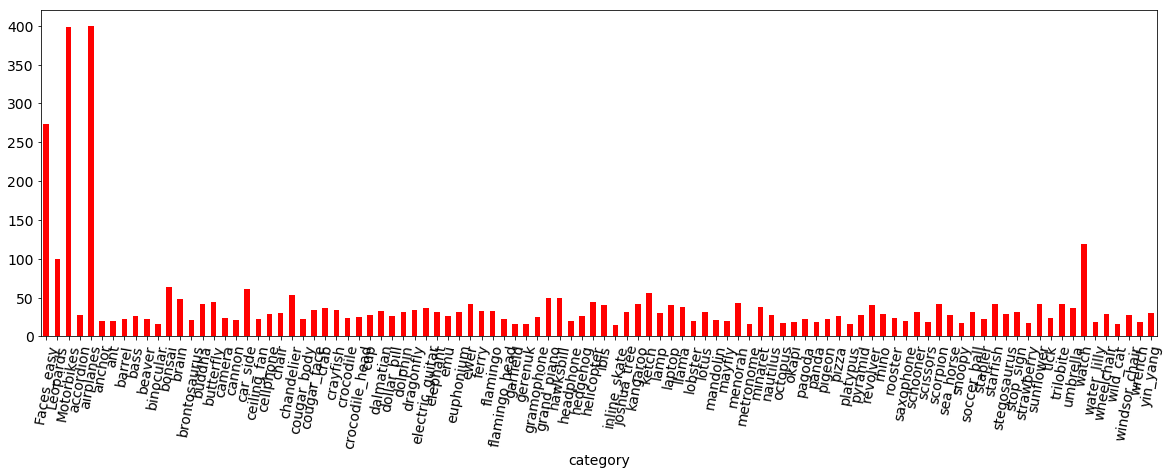

In [72]:
cat_df.set_index('category')['n_train'].plot.bar(color = 'r',
                                             figsize = (20, 6))
plt.xticks(rotation = 80);

In [28]:
image_df.groupby('category').describe()

height                                                       \
                count        mean        std    min     25%    50%     75%   
category                                                                     
Faces_easy      435.0  318.894253  24.333566  237.0  302.00  318.0  332.00   
Leopards        200.0  138.240000  23.521665  128.0  128.00  128.0  128.00   
Motorbikes      798.0  164.946115  18.790754  121.0  152.00  163.0  175.00   
accordion        55.0  255.672727  35.771939  191.0  225.50  255.0  300.00   
airplanes       800.0  157.807500  27.343327  101.0  141.00  154.0  170.00   
anchor           42.0  249.714286  41.774240  167.0  224.25  256.0  294.75   
ant              42.0  212.285714  43.884708  103.0  178.75  209.5  238.25   
barrel           47.0  290.319149  27.614667  188.0  300.00  300.0  300.00   
bass             54.0  187.111111  45.003005  129.0  148.50  181.0  205.75   
beaver           46.0  221.826087  42.358420  153.0  193.25  214.0  240.75   
binocular        33.0  275.333333  36.555323  150.0  245.00  298.0  300.00   
bonsai          128.0  280.609375  32.330779  164.0  269.75  300.0  300.00   
brain            98.0  247.775510  30.491010  170.0  225.00  249.0  266.50   
brontosaurus     43.0  227.697674  46.333437  130.0  196.00  221.0  260.50   
buddha           85.0  293.564706  19.652606  219.0  300.00  300.0  300.00   
butterfly        91.0  246.538462  37.842747  178.0  216.00  248.0  278.00   
camera           50.0  251.520000  40.968500  156.0  225.00  247.5  297.75   
cannon           43.0  230.813953  37.531102  160.0  206.50  225.0  264.00   
car_side        123.0  197.000000   0.000000  197.0  197.00  197.0  197.00   
ceiling_fan      47.0  191.106383  36.782696   92.0  164.50  192.0  224.50   
cellphone        59.0  283.762712  35.508299  164.0  296.50  300.0  300.00   
chair            62.0  296.983871  11.324559  225.0  300.00  300.0  300.00   
chandelier      107.0  273.906542  34.510740  191.0  242.50  300.0  300.00   
cougar_body      47.0  237.489362  52.251429  133.0  196.50  226.0  300.00   
cougar_face      69.0  279.898551  26.441470  188.0  266.00  290.0  300.00   
crab             73.0  229.575342  38.568452  174.0  199.00  225.0  255.00   
crayfish         70.0  216.157143  30.618568  147.0  200.00  217.5  229.50   
crocodile        50.0  180.660000  36.069440  115.0  157.00  180.5  200.00   
crocodile_head   51.0  233.450980  35.085218  174.0  209.50  225.0  258.00   
cup              57.0  263.614035  35.377431  174.0  233.00  269.0  300.00   
...               ...         ...        ...    ...     ...    ...     ...   
pigeon           45.0  249.422222  37.051248  185.0  220.00  254.0  279.00   
pizza            53.0  248.188679  38.885956  155.0  225.00  238.0  287.00   
platypus         34.0  236.794118  45.957674  160.0  203.00  225.0  289.25   
pyramid          57.0  233.421053  40.292213  173.0  200.00  221.0  270.00   
revolver         82.0  198.439024  38.146921  145.0  166.75  196.0  215.25   
rhino            59.0  209.745763  27.339244  155.0  195.00  204.0  224.50   
rooster          49.0  282.816327  27.015176  204.0  269.00  300.0  300.00   
saxophone        40.0  294.725000  15.843768  221.0  300.00  300.0  300.00   
schooner         63.0  245.619048  40.788371  124.0  214.00  242.0  283.00   
scissors         39.0  292.128205  27.084837  153.0  300.00  300.0  300.00   
scorpion         84.0  228.607143  35.187285  153.0  201.75  225.0  247.25   
sea_horse        57.0  280.087719  35.154395  176.0  276.00  300.0  300.00   
snoopy           35.0  280.371429  30.624947  197.0  275.00  300.0  300.00   
soccer_ball      64.0  274.078125  37.829737  179.0  256.00  295.5  300.00   
stapler          45.0  244.088889  48.711499  147.0  206.00  248.0  300.00   
starfish         86.0  260.372093  38.915307  124.0  225.00  275.0  295.75   
stegosaurus      59.0  206.593220  31.497191  147.0  186.50  200.0  225.00   
stop_sign        64.0  277.953125  34

In [29]:
def imshow(image):
    plt.figure(figsize = (6, 6))
    plt.imshow(image)
    plt.axis('off');
    plt.show();

In [31]:
x = Image.open(datadir + 'ewer/image_0002.jpg')
np.array(x).shape

(300, 187, 3)

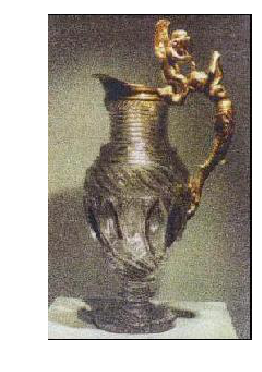

In [32]:
imshow(x);

In [74]:

image_transforms = {
        'train': transforms.Compose([
                 transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                 transforms.RandomHorizontalFlip(),
                 transforms.CenterCrop(size=224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
     'test': transforms.Compose([
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

batch_size = 16

# Datasets
data = {'train': datasets.ImageFolder(root=traindir,
                                      transform=image_transforms['train']),
        'val': datasets.ImageFolder(root=validdir,
                                     transform=image_transforms['val']),
        'test': datasets.ImageFolder(root=testdir,
                                     transform=image_transforms['test'])
       }

dataloaders = {'train': DataLoader(data['train'], batch_size=batch_size),
              'val': DataLoader(data['val'], batch_size=batch_size),
               'test': DataLoader(data['test'], batch_size=batch_size)
              }

In [60]:
for c in cat_df['category']:
#     os.mkdir(datadir + '/test/' + c)
#     os.mkdir(datadir + '/train/' + c)
    os.mkdir(datadir + '/valid/' + c)

In [47]:
%%capture
for i, row in cat_df.iterrows():
    train_num = int(0.75 * row['n'])
    images = os.listdir(datadir + row['category'])
    train_imgs = list(np.random.choice(images, 
                     size = train_num, replace = False))
    test_imgs = [i for i in images if i not in train_imgs]
    assert (len(images) == (len(train_imgs) + len(test_imgs))), 'Images must be in either training or testing set'
    for i in train_imgs:
        os.system(f'cp {datadir + row["category"] + "/" + i} {datadir + "train/" + row["category"] + "/" + i}')
    for i in test_imgs:
        os.system(f'cp {datadir + row["category"] + "/" + i} {datadir + "test/" + row["category"] + "/" + i}')

In [65]:
for i, row in cat_df.iterrows():
    images = os.listdir(datadir + 'train/' + row['category'])
    train_num = int((2 / 3) * len(images))
    train_imgs = list(np.random.choice(images, 
                     size = train_num, replace = False))
    valid_imgs = [i for i in images if i not in train_imgs]
    assert (len(images) == (len(train_imgs) + len(valid_imgs))), 'Images must be in either training or validation set'
    
    for i in valid_imgs:
        os.system(f'mv {datadir + "train/" + row["category"] + "/" + i} {datadir + "valid/" + row["category"] + "/" + i}')

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

In [64]:
cat_df

category    n
39      Faces_easy  435
11        Leopards  200
26      Motorbikes  798
54       accordion   55
80       airplanes  800
74          anchor   42
87             ant   42
20          barrel   47
32            bass   54
3           beaver   46
8        binocular   33
85          bonsai  128
36           brain   98
31    brontosaurus   43
7           buddha   85
75       butterfly   91
45          camera   50
22          cannon   43
69        car_side  123
28     ceiling_fan   47
99       cellphone   59
49           chair   62
0       chandelier  107
95     cougar_body   47
93     cougar_face   69
1             crab   73
61        crayfish   70
71       crocodile   50
50  crocodile_head   51
15             cup   57
..             ...  ...
24          pigeon   45
63           pizza   53
79        platypus   34
12         pyramid   57
34        revolver   82
29           rhino   59
98         rooster   49
70       saxophone   40
13        schooner   63
43        scissors   39
86        scorpion   84
25       sea_horse   57
83          snoopy   35
56     soccer_ball   64
67         stapler   45
68        starfish   86
46     stegosaurus   59
94       stop_sign   64
97      strawberry   35
2        sunflower   85
62            tick   49
14       trilobite   86
78        umbrella   75
72           watch  239
81     water_lilly   37
88      wheelchair   59
52        wild_cat   34
42   windsor_chair   56
77          wrench   39
48        yin_yang   60

[100 rows x 2 columns]

In [62]:
train_imgs

['image_0131.jpg',
 'image_0154.jpg',
 'image_0384.jpg',
 'image_0220.jpg',
 'image_0214.jpg',
 'image_0034.jpg',
 'image_0435.jpg',
 'image_0229.jpg',
 'image_0165.jpg',
 'image_0044.jpg',
 'image_0350.jpg',
 'image_0265.jpg',
 'image_0426.jpg',
 'image_0290.jpg',
 'image_0340.jpg',
 'image_0093.jpg',
 'image_0070.jpg',
 'image_0406.jpg',
 'image_0128.jpg',
 'image_0325.jpg',
 'image_0069.jpg',
 'image_0272.jpg',
 'image_0227.jpg',
 'image_0280.jpg',
 'image_0203.jpg',
 'image_0351.jpg',
 'image_0111.jpg',
 'image_0415.jpg',
 'image_0251.jpg',
 'image_0144.jpg',
 'image_0269.jpg',
 'image_0088.jpg',
 'image_0060.jpg',
 'image_0188.jpg',
 'image_0023.jpg',
 'image_0187.jpg',
 'image_0200.jpg',
 'image_0240.jpg',
 'image_0208.jpg',
 'image_0110.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0073.jpg',
 'image_0077.jpg',
 'image_0009.jpg',
 'image_0398.jpg',
 'image_0241.jpg',
 'image_0139.jpg',
 'image_0125.jpg',
 'image_0057.jpg',
 'image_0136.jpg',
 'image_0052.jpg',
 'image_0230

In [63]:
valid_imgs

['image_0379.jpg',
 'image_0190.jpg',
 'image_0171.jpg',
 'image_0431.jpg',
 'image_0304.jpg',
 'image_0413.jpg',
 'image_0212.jpg',
 'image_0427.jpg',
 'image_0051.jpg',
 'image_0319.jpg',
 'image_0423.jpg',
 'image_0330.jpg',
 'image_0252.jpg',
 'image_0032.jpg',
 'image_0013.jpg',
 'image_0196.jpg',
 'image_0182.jpg',
 'image_0040.jpg',
 'image_0065.jpg',
 'image_0341.jpg',
 'image_0248.jpg',
 'image_0098.jpg',
 'image_0327.jpg',
 'image_0300.jpg',
 'image_0238.jpg',
 'image_0245.jpg',
 'image_0081.jpg',
 'image_0255.jpg',
 'image_0287.jpg',
 'image_0380.jpg',
 'image_0206.jpg',
 'image_0353.jpg',
 'image_0432.jpg',
 'image_0388.jpg',
 'image_0038.jpg',
 'image_0059.jpg',
 'image_0068.jpg',
 'image_0151.jpg',
 'image_0039.jpg',
 'image_0116.jpg',
 'image_0014.jpg',
 'image_0293.jpg',
 'image_0160.jpg',
 'image_0092.jpg',
 'image_0041.jpg',
 'image_0324.jpg',
 'image_0121.jpg',
 'image_0323.jpg',
 'image_0026.jpg',
 'image_0383.jpg',
 'image_0226.jpg',
 'image_0095.jpg',
 'image_0273